Кластеризация данных о пассажирах авиакомпаний

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder


from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

sns.set_theme(style="whitegrid")


Описание датасета

Исходный датасет состоит из 103 904 записей и 25 признаков, среди которых представлены демографические характеристики, параметры полета и оценки качества обслуживания. 

Признаки как числовые, так и категориальные. К числовым относятся возраст, расстояние полета и различные оценки качества сервиса, к категориальным - пол, тип клиента, класс обслуживания, тип поездки и уровень удовлетворенности пассажиров. 

Анализ пропусков выявил единичные отсутствующие значения в признаке Arrival Delay in Minutes (310 записей).

Гистограммы ключевых числовых признаков показали ненормальность распределений.

Распределения числовых признаков (например, возраст, задержки) демонстрируют правостороннюю асимметрию: значительная часть пассажиров - взрослые (медианный возраст 40 лет), большинство перелетов - средней и большой дальности, при этом задержки часто отсутствуют, но имеют редкие экстремальные значения (до 1592 минут). Категориальные признаки показывают преобладание лояльных клиентов (82 %), бизнес-путешествий (69 %) и удовлетворенности на уровне 43 %. Выявлено 310 пропущенных значений в Arrival Delay in Minutes, а также 3103 нулевых оценок по Inflight wifi service, интерпретированных как отсутствие данных и удалённых из анализа. Класс Eco Plus исключён из-за малочисленности.

Shape: (103904, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location      

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,103904.0,51951.500000,29994.645522,0.0,25975.75,51951.5,77927.25,103903.0
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
Flight Distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
Inflight wifi service,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
Departure/Arrival time convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
Ease of Online booking,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
Gate location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
Food and drink,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
Online boarding,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0


Gender distribution:
 Gender
Female    52727
Male      51177
Name: count, dtype: int64 

Customer Type distribution:
 Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64 

Type of Travel distribution:
 Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64 

Class distribution:
 Class
Business    49665
Eco         46745
Eco Plus     7494
Name: count, dtype: int64 

satisfaction distribution:
 satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64 



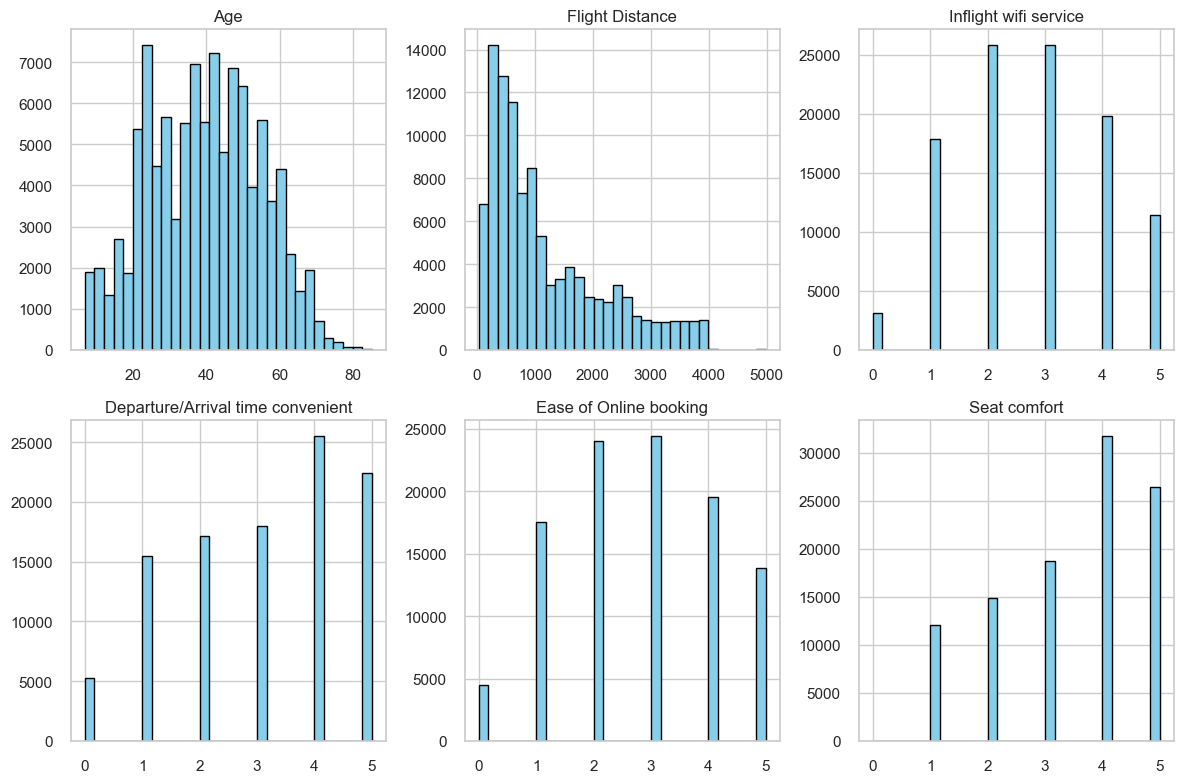

In [49]:
data = pd.read_csv("train.csv")

# Основная информация о датасете
print("Shape:", data.shape)
print(data.info())
print("Missing values:\n", data.isnull().sum())
display(data.describe().T)

# Проверка распределения категориальных признаков
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
for col in cat_cols:
    print(f"{col} distribution:\n", data[col].value_counts(), "\n")

# Проверка распределения числовых признаков
num_cols = ["Age", "Flight Distance", "Inflight wifi service",
            "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.show()

Все категориальные переменные закодированы бинарно (0/1). Числовые признаки масштабированы с использованием StandardScaler, что обеспечивает равный вклад всех переменных в расстояние при кластеризации. 

Из-за сильной корреляции между Departure Delay и Arrival Delay (0.97) второй признак удалён. 

Для снижения размерности и визуализации применён PCA: выбраны первые три главные компоненты, объясняющие основную дисперсию данных (суммарно >80 %).

In [ ]:
# Удаляем строки с некорректными/нулевыми значениями
data = data[data['Inflight wifi service'] != 0]
data = data[data['Class'] != 'Eco Plus']

# Преобразуем категориальные признаки в числовые
mapping = {
    'Gender': {'Female': 0, 'Male': 1},
    'Customer Type': {'Loyal Customer': 0, 'disloyal Customer': 1},
    'Type of Travel': {'Business travel': 0, 'Personal Travel': 1},
    'Class': {'Business': 0, 'Eco': 1},
    'satisfaction': {'neutral or dissatisfied': 0, 'satisfied': 1}
}
data = data.replace(mapping)

# Удаляем лишние столбцы
data = data.drop(columns=['id', 'Unnamed: 0', 'Arrival Delay in Minutes'])

satisfaction = data['satisfaction'].copy()
data = data.drop(columns=['satisfaction'])

C:\Users\vfvjx\AppData\Local\Temp\ipykernel_12556\555576555.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(mapping)


In [51]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

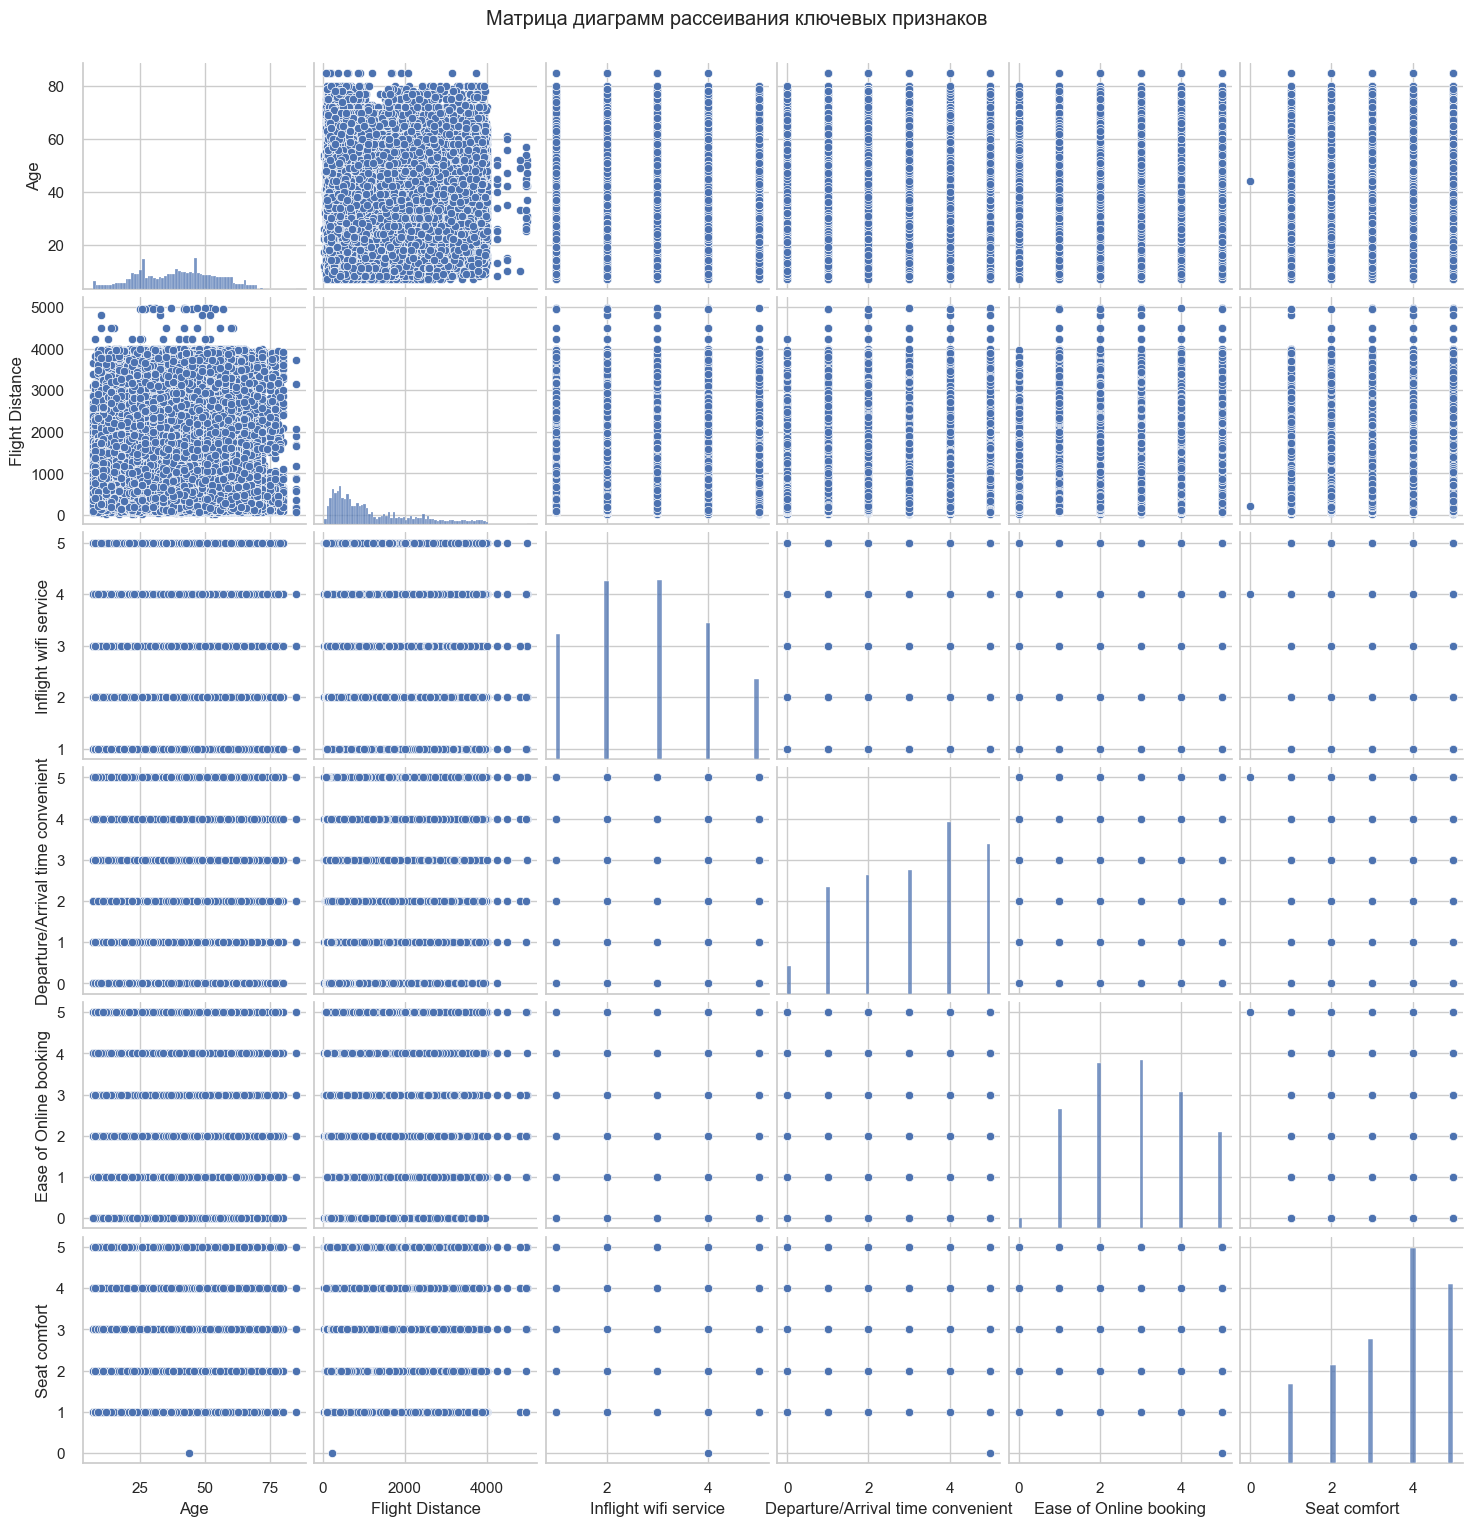

In [52]:
# PCA для снижения размерности для визуализации
pca = PCA(n_components=3, random_state=42)
data_pca = pd.DataFrame(pca.fit_transform(data_scaled), columns=['PC1', 'PC2', 'PC3'])

# Матрица диаграмм рассеивания ключевых признаков
key_features = ["Age", "Flight Distance", "Inflight wifi service",
                "Departure/Arrival time convenient", "Ease of Online booking", "Seat comfort"]
sns.pairplot(data[key_features])
plt.suptitle("Матрица диаграмм рассеивания ключевых признаков", y=1.02)
plt.show()

С использованием метода локтя (через KElbowVisualizer) на PCA-пространстве было установлено, что оптимальное число кластеров для K-means - 4.

Кластеризация с использованием KMeans позволила выявить 4 различимые группы пассажиров, которые визуализированы в трехмерном пространстве PCA.

Silhouette Score очень низкий (0.105) - кластеры плохо отделены, границы размытые.
Calinski-Harabasz Score довольно высокий (10345) - внутреннее распределение плотное, но из-за большого объёма данных это не гарантирует хорошую кластеризацию.

Вывод: кластеры существуют, но выражены слабо, границы между ними нечёткие.

Профили кластеров:

Cluster 0: старшие бизнес-путешественники, довольны сервисом.

Cluster 1: молодые, недовольные, эконом-класс, короткие полеты.

Cluster 2: редкие бизнес-путешественники, критичны к wifi и расписанию.

Cluster 3: семьи на отдыхе, ценят сервис и пространство.

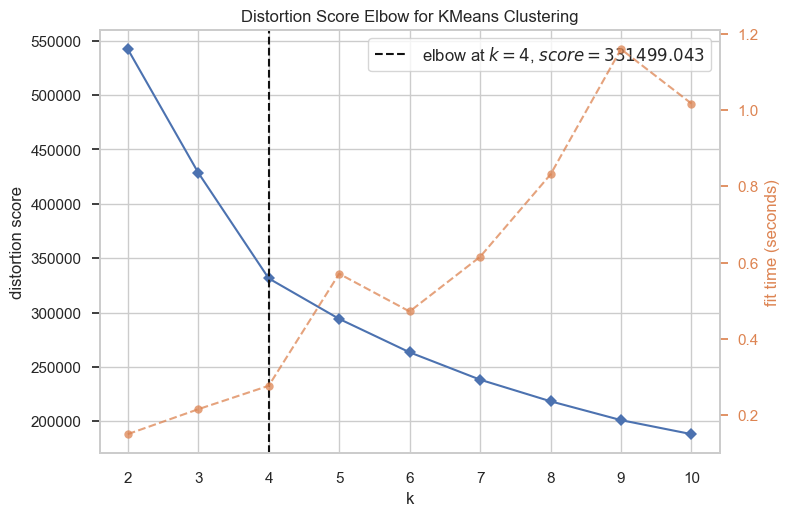

Optimal k: 4


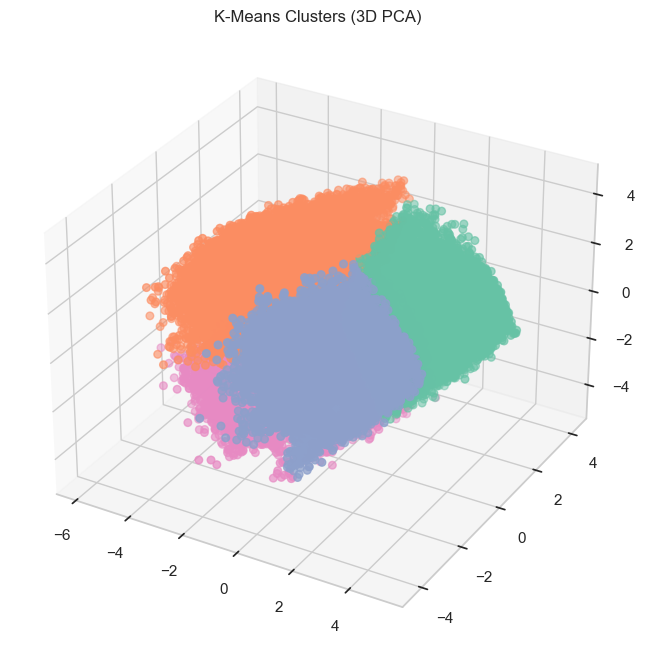

Silhouette Score: 0.105, Calinski-Harabasz Score: 10345.783


KMeansCluster,0,1,2,3
Gender,0.497695,0.544018,0.494462,0.440888
Customer Type,0.107986,0.334432,0.160722,0.151943
Age,42.119962,32.801953,40.811613,42.092518
Type of Travel,0.153528,0.464858,0.193755,0.383424
Class,0.242328,0.757238,0.301000,0.650127
Flight Distance,1541.972856,849.923883,1443.324909,1063.349873
Inflight wifi service,4.016192,2.428511,1.945499,2.654300
Departure/Arrival time convenient,4.010125,3.096023,2.025518,2.976881
Ease of Online booking,3.994169,2.579054,1.814930,2.783374
Gate location,3.834141,2.971768,1.925104,2.993073


In [53]:
# Определяем оптимальное число кластеров методом локтя
elbow = KElbowVisualizer(KMeans(n_init=10, random_state=42), k=10)
elbow.fit(data_pca)
elbow.show()
optimal_k = elbow.elbow_value_
print("Optimal k:", optimal_k)

# Строим модель K-Means
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)
data_pca['KMeansCluster'] = kmeans_labels
data['KMeansCluster'] = kmeans_labels

# Визуализация кластеров
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap = colors.ListedColormap(sns.color_palette("Set2", optimal_k))
ax.scatter(data_pca['PC1'], data_pca['PC2'], data_pca['PC3'], c=data_pca['KMeansCluster'], cmap=cmap, s=30)
ax.set_title("K-Means Clusters (3D PCA)")
plt.show()

# Метрики качества
sil_score = silhouette_score(data_scaled, kmeans_labels)
ch_score = calinski_harabasz_score(data_scaled, kmeans_labels)
print(f"Silhouette Score: {sil_score:.3f}, Calinski-Harabasz Score: {ch_score:.3f}")

# Профили кластеров
cluster_profiles = data.groupby('KMeansCluster').mean().T
display(cluster_profiles.style.background_gradient(cmap='RdYlGn', axis=1))

Иерархическая кластеризация проводилась с использованием расстояния Хэмминга для категориальных признаков. Дендограмма позволила визуально оценить структуру данных. Анализ профилей кластеров показал, что иерархический метод формирует группы, аналогичные KMeans, однако распределение объектов по кластерам более неравномерное.

Метрики качества:

Silhouette Score (Hamming distance): 0.104  такой же низкий, как у K-Means.

Calinski-Harabasz Score: 451.871 значительно ниже, т.к. меньше объектов (выборка 5000).

Davies-Bouldin Score: 2.880 довольно высокое значение, кластеры не компактные.

Профили кластеров:

Cluster 2: старшие, бизнес-класс, довольны сервисом.

Cluster 1: младшие, личные поездки, критичны к сервису.

Cluster 3: смешанный состав, средние оценки.

Cluster 4: редкие, более старшие, ограниченные услуги.

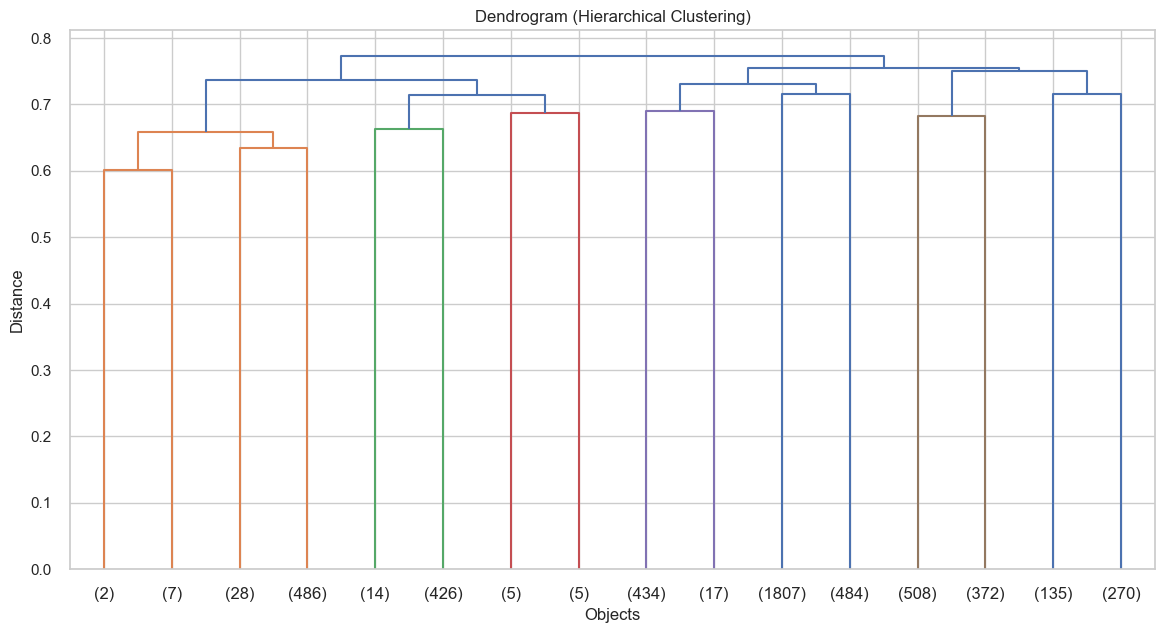

HierCluster
2    2742
1     973
3     880
4     405
Name: count, dtype: int64


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,KMeansCluster
HierCluster,,,,,,,,,,,,,,,,,,,,,
1,1,0,24,0,1,399,2,4,3,3,...,2,2,3,4,4,3,4,2,0,1
2,0,0,39,0,0,373,4,4,3,3,...,4,4,4,4,4,4,4,4,0,0
3,1,0,27,0,1,337,3,4,3,3,...,3,3,3,3,3,3,3,3,0,3
4,0,0,49,0,0,2586,2,4,4,3,...,4,2,2,2,2,3,2,4,0,3


In [54]:
sample = data.sample(5000, random_state=42)

# Вычисление матрицы расстояний (Hamming для категориальных признаков)
dist_matrix = pdist(sample, metric='hamming')

# Строим дендрограмму
Z = linkage(dist_matrix, method='average')
plt.figure(figsize=(14, 7))
dendrogram(Z, truncate_mode='level', p=3, color_threshold=0.7)
plt.title("Dendrogram (Hierarchical Clustering)")
plt.xlabel("Objects")
plt.ylabel("Distance")
plt.show()

# Формируем кластеры
k_hier = 4
hier_labels = fcluster(Z, k_hier, criterion='maxclust')
sample['HierCluster'] = hier_labels
print(sample['HierCluster'].value_counts())

# Профили кластеров
cluster_profiles_hier = sample.groupby('HierCluster').agg(lambda x: x.value_counts().index[0])
display(cluster_profiles_hier)

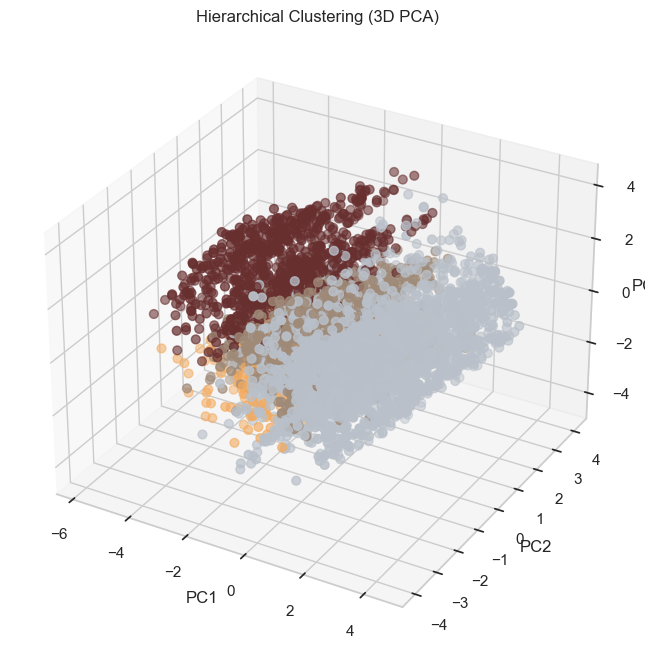

In [ ]:
cat_cols_sample = [
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class',
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

sample_encoded = sample.copy()
for col in cat_cols_sample:
    le = LabelEncoder()
    sample_encoded[col] = le.fit_transform(sample_encoded[col])

scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample_encoded[cat_cols_sample])

pca = PCA(n_components=3, random_state=42)
sample_pca = pca.fit_transform(sample_scaled)
sample_pca_df = pd.DataFrame(sample_pca, columns=['PC1', 'PC2', 'PC3'])
sample_pca_df['Cluster'] = sample['HierCluster'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = colors.ListedColormap(['#682F2F','#B9C0C9', '#9F8A78', '#F3AB60'])
scatter = ax.scatter(
    sample_pca_df['PC1'], 
    sample_pca_df['PC2'], 
    sample_pca_df['PC3'], 
    c=sample_pca_df['Cluster'], 
    cmap=cmap, 
    s=40
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("Hierarchical Clustering (3D PCA)")

plt.show()


In [56]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import squareform

dist_square = squareform(dist_matrix)

# Silhouette Score (используем precomputed)
sil_score = silhouette_score(dist_square, hier_labels, metric='precomputed')

num_cols = sample.select_dtypes(include=np.number).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample[num_cols])

ch_score = calinski_harabasz_score(sample_scaled, hier_labels)
db_score = davies_bouldin_score(sample_scaled, hier_labels)

print(f"Hierarchical Clustering Metrics:")
print(f"Silhouette Score (Hamming distance): {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


Hierarchical Clustering Metrics:
Silhouette Score (Hamming distance): 0.104
Calinski-Harabasz Score: 451.871
Davies-Bouldin Score: 2.880


K-Means: кластеры относительно равномерные, но низкая Silhouette говорит о пересечении кластеров.

Иерархическая кластеризация: кластеры сильно неравномерны по численности. Выделяются маленькие, специфические группы.

In [57]:
print("K-Means vs Hierarchical cluster sizes:")
print(data['KMeansCluster'].value_counts())
print(sample['HierCluster'].value_counts())

K-Means vs Hierarchical cluster sizes:
KMeansCluster
0    25383
3    23963
1    23661
2    20495
Name: count, dtype: int64
HierCluster
2    2742
1     973
3     880
4     405
Name: count, dtype: int64


Заключение: 

В сравнении двух методов кластеризации видно, что K-Means выделяет кластеры более равномерно по размеру, с умеренным качеством (Silhouette 0.105, Calinski-Harabasz 10345), тогда как иерархическая кластеризация формирует сильно неравные группы, с близким Silhouette (0.104), но существенно меньшим Calinski-Harabasz (451), что указывает на меньшую плотность и различимость кластеров.

Для данного набора данных, содержащего как числовые, так и категориальные признаки, K-Means (с предварительным кодированием и стандартизацией) обеспечивает более стабильные и интерпретируемые сегменты, в то время как иерархическая полезна для выявления редких профилей, но менее практична для масштабных данных.